In [1]:
from config import cfg
from model import BERT_ENCODER, G_NET
from preprocessing_bert import to_bert_tokens, to_attention_mask, to_bert_token_indices
import pickle
import numpy as np
from PIL import Image
import transformers
import torch
from torch.autograd import Variable

In [2]:
tokenizer = transformers.BertTokenizer.from_pretrained(cfg.BERT_PATH)

In [3]:
text_encoder = BERT_ENCODER()
if cfg.CUDA:
    text_encoder = text_encoder.cuda()
for p in text_encoder.parameters():
    p.requires_grad = False
text_encoder.eval()

BERT_ENCODER(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )


In [4]:
netG_flower = G_NET()
netG_flower_params = torch.load('flower/netG_epoch_350.pth')
netG_flower.load_state_dict(netG_flower_params)
if cfg.CUDA:
    netG_flower = netG_flower.cuda()

In [5]:
def show_img(im, imsize = 128):
    # [-1, 1] --> [0, 255]
    im = (im + 1.0) * 127.5
    im = im.astype(np.uint8)
    im = np.transpose(im, (1, 2, 0))
    im = Image.fromarray(im)
    display(im.resize((imsize, imsize)))

def txt2img(caps, netG, tokenizer, only_last = False):
    nz = cfg.GAN.Z_DIM
    batch_size = len(caps)    
    caps_bert = to_bert_tokens([caps], tokenizer, max_len = cfg.TEXT.WORDS_NUM)
    attn_masks = to_attention_mask(caps_bert)
    caps_bert = to_bert_token_indices(caps_bert, tokenizer)
    caps_bert = Variable(torch.LongTensor(caps_bert).squeeze(0))
    attn_masks = Variable(torch.LongTensor(attn_masks).squeeze(0))
    if cfg.CUDA:
        caps_bert = caps_bert.cuda()
        attn_masks = attn_masks.cuda()

    noise = Variable(torch.FloatTensor(batch_size, nz))
    fixed_noise = Variable(torch.FloatTensor(batch_size, nz).normal_(0, 1))
    segs_ids = Variable(torch.LongTensor(25).fill_(0))
    if cfg.CUDA:
        noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
        segs_ids = segs_ids.cuda()
    mask = (caps_bert == 0)
    words_embs, sent_emb = text_encoder(caps_bert, attn_masks, segs_ids)
    words_embs, sent_emb = words_embs.detach(), sent_emb.detach()
    noise.data.normal_(0, 1)
    netG.eval()
    with torch.no_grad():
        fake_imgs, _, _, _ = netG(noise, sent_emb, words_embs, mask)
    for i in range(batch_size):
        print(caps[i])
        if only_last:
            fake_imgs = [fake_imgs[-1]]
        for imgs in fake_imgs:
            show_img(imgs[i].data.cpu().numpy())
    netG.train()
    
def sample_from_testset(caps_test, attn_mask_test, text_test,
                        netG, num_samples = 10, only_last = False):
    nz = cfg.GAN.Z_DIM
    imsize = 128
    rng = np.random.choice(len(caps_test), num_samples)
    caps_bert = np.array(caps_test)[rng]
    attn_masks = np.array(attn_mask_test)[rng]
    caps = np.array(text_test)[rng]
    caps_bert = Variable(torch.LongTensor(caps_bert).squeeze(0))
    attn_masks = Variable(torch.LongTensor(attn_masks).squeeze(0))
    if cfg.CUDA:
        caps_bert = caps_bert.cuda()
        attn_masks = attn_masks.cuda()
            
    noise = Variable(torch.FloatTensor(num_samples, nz))
    fixed_noise = Variable(torch.FloatTensor(num_samples, nz).normal_(0, 1))
    segs_ids = Variable(torch.LongTensor(25).fill_(0))
    if cfg.CUDA:
        noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
        segs_ids = segs_ids.cuda()
    mask = (caps_bert == 0)
    words_embs, sent_emb = text_encoder(caps_bert, attn_masks, segs_ids)
    words_embs, sent_emb = words_embs.detach(), sent_emb.detach()
    noise.data.normal_(0, 1)
    netG.eval()
    with torch.no_grad():
        fake_imgs, _, _, _ = netG(noise, sent_emb, words_embs, mask)
    for i in range(num_samples):
        print(caps[i])
        if only_last:
            fake_imgs = [fake_imgs[-1]]
        for imgs in fake_imgs:
            show_img(imgs[i].data.cpu().numpy())
    netG.train()

this flower has petals that are orange and has black dots


/home/jupyter/GlobalAttention.py:108: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn = self.sm(attn)  # Eq. (2)


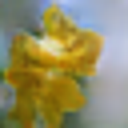

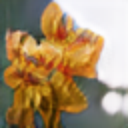

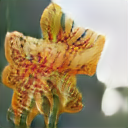

In [6]:
caps = ['this flower has petals that are orange and has black dots']
txt2img(caps, netG_flower, tokenizer)

this white flower has connected circular petals with yellow stamen


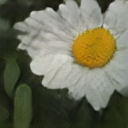

this flower has petals that are purple and has white shading


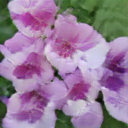

In [62]:
caps = ['this white flower has connected circular petals with yellow stamen', 
        'this flower has petals that are purple and has white shading']
txt2img(caps, netG_flower, tokenizer, only_last = True)

In [8]:
FLOWER_DATA_DIR = './flower'
BIRD_DATA_DIR = './bird'

with open(FLOWER_DATA_DIR + '/token_bert_test.pkl', 'rb') as f:
    caps_flower_test = pickle.load(f)
with open(FLOWER_DATA_DIR + '/attn_mask_test.pkl', 'rb') as f:
    attn_mask_flower_test = pickle.load(f)
with open(FLOWER_DATA_DIR + '/caps_text_test.pkl', 'rb') as f:
    text_flower_test = pickle.load(f)
    
caps_flower_test = [cap for caps in caps_flower_test for cap in caps]
attn_mask_flower_test = [am for ams in attn_mask_flower_test for am in ams]
text_flower_test = [text for texts in text_flower_test for text in texts]

this flower has very large light pink petals with uneven edges


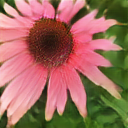

this bright yellow flower has a bevy of solid yellow outer petals and a large inner stamen area


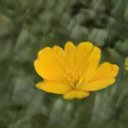

the 5 large petals of this flower are light pink with darker pink ridges up the center tapering to a trumpet shaped receptacle


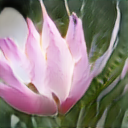

this is a flower with white petals and a green pedicel


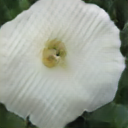

this flower has long light green petals under needle like lavender white and purple petals


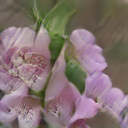

this plant appears to have a single , white , star shaped pedal surrounding the white anthers


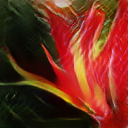

this crazy-looking flower features wavy stamen against a darker-purple petal-set


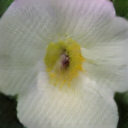

this flower has all white petals with orange stamen


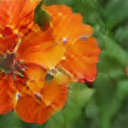

the flower is a delicate blue that forms a neat circle with a starfish pattern on the inside leading to a yellow center


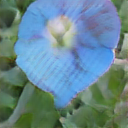

this flower is white and yellow in color , with petals that are rounded


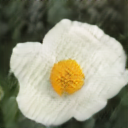

In [65]:
sample_from_testset(caps_flower_test, attn_mask_flower_test, text_flower_test,
                        netG_flower, num_samples = 10, only_last = True)

In [10]:
netG_bird = G_NET()
netG_bird_params = torch.load(BIRD_DATA_DIR + '/netG_epoch_350.pth')
netG_bird.load_state_dict(netG_bird_params)
if cfg.CUDA:
    netG_bird = netG_bird.cuda()

this bird has a red stripe


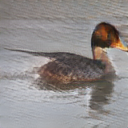

this small bird has a short pointed bill with dark brown,　orange　brown, tan, and white covering the rest of its body


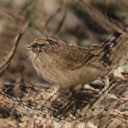

this is a multicolored bird with a light shade on its lower part , orange breast , blue head and small beak


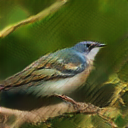

In [55]:
caps = ['this bird has a red stripe', 
        'this small bird has a short pointed bill with dark brown,　orange　brown, tan, and white covering the rest of its body', 
        'this is a multicolored bird with a light shade on its lower part , orange breast , blue head and small beak']
txt2img(caps, netG_bird, tokenizer, only_last = True)

In [12]:
with open(BIRD_DATA_DIR + '/token_bert_test.pkl', 'rb') as f:
    caps_bird_test = pickle.load(f)
with open(BIRD_DATA_DIR + '/attn_mask_test.pkl', 'rb') as f:
    attn_mask_bird_test = pickle.load(f)
with open(BIRD_DATA_DIR + '/caps_text_test.pkl', 'rb') as f:
    text_bird_test = pickle.load(f)
    
caps_bird_test = [cap for caps in caps_bird_test for cap in caps]
attn_mask_bird_test = [am for ams in attn_mask_bird_test for am in ams]
text_bird_test = [text for texts in text_bird_test for text in texts]

this bird is white with brown and has a very short beak


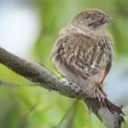

this bird is grey with yellow on its head and has a long , pointy beak


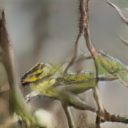

this is a black bird with black feet and a red eye


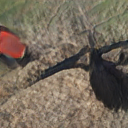

a small bird with black bill , tarsus and feet , and white wings with black wingbars


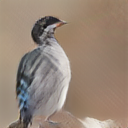

this bird has a brown crown , brown primaries , and a brown throat


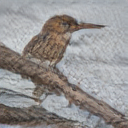

this small bird has a grey colored crown with dark brown wings


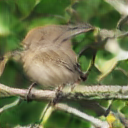

this particular bird has a belly that is orange and yellow


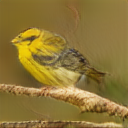

a small bird with a cream body and chest , tan wings and rectrices and a copper crown


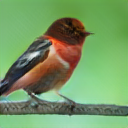

the crown of the bird is comprised of yellow and black tones , and the bill is short and pointed


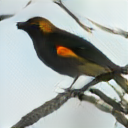

the small bird has a narrow throat and neck , a long gray bill and a white belly


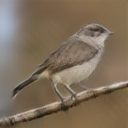

In [13]:
sample_from_testset(caps_bird_test, attn_mask_bird_test, text_bird_test,
                        netG_bird, num_samples = 10, only_last = True)